## MNIST

In [1]:
import pandas as pd
import numpy as np
import statistics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
import tensorflow.keras.backend as K
import sys
sys.path.append('../../')
from tensorflow.keras.datasets import mnist
from src.elm.elms import ClassicELM, ToeplitzELM, CirculantELM, FastFoodELM, ToeplitzLikeELM, VandermondeELM, LowRankELM
import hpelm
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import RandomNormal
import math
import scipy
import scipy.stats as stats
import pickle

# Preprocessing

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train = np.reshape(x_train, [60000, 28*28])
x_test = np.reshape(x_test, [10000, 28*28])

In [4]:
number = 9
y_train = (y_train == number).astype(int)
y_test = (y_test == number).astype(int)

y_train[y_train == 0] = -1
y_test[y_test == 0] = -1

y_train_hp = np.expand_dims(y_train, -1)
y_test_hp = np.expand_dims(y_test, -1)

## Figure 3.1

In [5]:
x = np.concatenate([x_train, x_test], axis=0);
x = x.flatten()

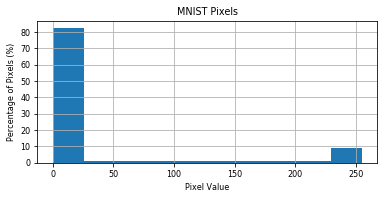

In [6]:
fig = plt.figure(figsize=(12/2.54, 5/2.54))
plt.rcParams.update({'font.size': 8})
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.rcParams.update({'font.size': 8})
hist, bins_ = np.histogram(x, bins=10)
freq = hist/np.sum(hist) * 100
plt.bar(bins_[:-1], freq, align="edge", width=np.diff(bins_))
plt.title("MNIST Pixels")
plt.ylabel("Percentage of Pixels (%)")
plt.xlabel("Pixel Value")
plt.yticks(np.linspace(0, 80, 9))
plt.grid(True)

plt.savefig("mnist/histogram.eps", format='eps', bbox_inches = 'tight',
    pad_inches = 0)

In [7]:
x = None

## Scaling

In [8]:
x_scaler = MinMaxScaler(feature_range=(0, 1))
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.transform(x_test)
x_scaler = None

In [9]:
shuffled = False

## Execute if training with shuffled pixels is desired

In [10]:
def create_permutation_matrix(permutation_list):
    length = len(permutation_list)
    perm_matrix = np.zeros([length, length])
    for i in range(length):
        perm_matrix[i, permutation_list[i]] = 1
    return perm_matrix

In [11]:
np.random.seed(42)
permutation_list =  np.random.permutation(np.random.permutation(np.random.permutation(range(28*28))))
np.random.seed(None)
P = create_permutation_matrix(permutation_list)

In [12]:
x_train = np.matmul(x_train, P)
x_test =  np.matmul(x_test, P)
shuffled = True

In [13]:
P = None
permutation_list = None

# Train method

In [14]:
def test(elm_class, neurons_number=5000, trial_number=6, print_every=1,
               regression_tool="ridge_sklearn", alpha=1e-11, dev=6, **kwargs):
    
    training_score = []
    testing_score = []
    
    stddev = dev / ((28*28) ** 0.5)
    for i in range(trial_number):
        elm = elm_class(hidden_neurons=[neurons_number], is_classifier=True, activation="sigmoid", input_shape=x_train[0].shape, use_bias=True,
                     kernel_initializer=RandomNormal(0, stddev), bias_initializer=RandomNormal(0, 1), dev=stddev,
                        **kwargs)
        elm.fit(x_train, y_train, regression_tool=regression_tool, alpha=alpha)
        training_score.append(elm.calculate_classification_accuracy(x_train, y_train))
        testing_score.append(elm.calculate_classification_accuracy(x_test, y_test))
        if (i + 1) % print_every == 0:
            print(f"{i + 1}/{trial_number} Training score: {training_score[i]:.{4}}. "
                  f"Testing score: {testing_score[i]:.{4}}")
        elm = None       
    return [training_score, testing_score]

def test_hpelm(neurons_number=5000, trial_number=3, print_every=1):
    hpelm_training_rmse = []
    hpelm_testing_rmse = []
    for i in range(trial_number):
        elm = hpelm.ELM(x_train.shape[1], y_train_hp.shape[1])
        elm.add_neurons(neurons_number, "sigm")
        elm.train(x_train, y_train_hp)
        hpelm_training_rmse.append(accuracy_score(y_train_hp > 0, elm.predict(x_train) > 0))
        hpelm_testing_rmse.append(accuracy_score(y_test_hp > 0, elm.predict(x_test) > 0))
        if(i + 1) % print_every == 0:
            print(f"{i + 1}/{trial_number} Training RMSE: {hpelm_training_rmse[i]:.{4}}. Testing RMSE: {hpelm_testing_rmse[i]:.{4}}")
    return [hpelm_training_rmse, hpelm_testing_rmse]    



def print_result(name, training_score, testing_score):
    print(name)
    print(f"Training Score: {statistics.mean(training_score):.{4}}")
    print(f"Testing Score: {statistics.mean(testing_score):.{4}}")

# Figure 3.3

In [15]:
with open(f"mnist/s.p", "rb") as file:
     [axis, results] = pickle.load(file)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


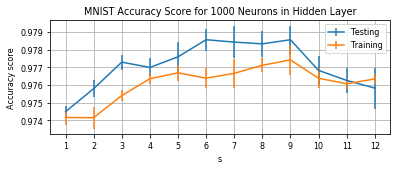

In [16]:
np_results = np.asarray(results)
fig = plt.figure(figsize=(12/2.54, 4/2.54))
plt.rcParams.update({'font.size': 8})
plt.errorbar(axis, np.mean(np_results, axis=-1)[:, 1], np.std(np_results, axis=-1)[:, 1], label="Testing")
plt.errorbar(axis, np.mean(np_results, axis=-1)[:, 0], np.std(np_results, axis=-1)[:, 0], label="Training")
plt.xticks(axis)
plt.legend()
plt.title("MNIST Accuracy Score for 1000 Neurons in Hidden Layer")
plt.xlabel("s")
plt.ylabel("Accuracy score")
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.grid(True)
plt.savefig("mnist/mnist_s.eps", format="eps", bbox_inches = 'tight',
    pad_inches = 0)

# Train the best ELMs
### Execution will take much time!

In [41]:
classical_scores = []
t_scores = []
c_scores = []
hpelm_scores = []

fastfood_scores = []
low_rank = []

neurons = []

In [6]:
for i in range(2, 4):
    n = i * 2000
    neurons.append(n)
    
    print(f"Neurons: {n}")
    
    print("Hpelm")
    hpelm_scores.append(test_hpelm(neurons_number=n))
    
    print("LowRank ELM")
    low_rank.append(test(ToeplitzLikeELM, neurons_number=n))
    
    print("My classical ELM")
    classical_scores.append(test(ClassicELM, neurons_number=n))
    
    print("Toeplitz ELM")
    t_scores.append(test(ToeplitzELM, neurons_number=n))

    print("Ciculant ELM")
    c_scores.append(test(CirculantELM, neurons_number=n))
    
    print("Fastfood ELM")
    fastfood_scores.append(test(FastFoodELM, neurons_number=n))

    result = [neurons, hpelm_scores, classical_scores, t_scores, c_scores, fastfood_scores, low_rank]
    with open(f"mnist/results{n}.p", "wb") as file:
        pickle.dump(result, file)

In [ ]:
result = [neurons, hpelm_scores, classical_scores, t_scores, c_scores, fastfood_scores, low_rank]
if shuffled:
    with open(f"mnist/results_permut_temp.p", "wb") as file:
            pickle.dump(result, file)
else:
    with open(f"mnist/results_temp.p", "wb") as file:
            pickle.dump(result, file)

# Train bad ELMs
### Execution will take much time!

In [2]:
if shuffled:
    vandermonde_4000 = test(VandermondeELM, neurons_number=4000, transpose=False, drop_ones=False)
    real_low_686_4000 = test(LowRankELM, neurons_number=4000, ranks=[686])
    real_low_392_4000 = test(LowRankELM, neurons_number=4000, ranks=[392])
    real_low_686_10000 = test(LowRankELM, neurons_number=10000, ranks=[686])
    real_low_392_10000 = test(LowRankELM, neurons_number=10000, ranks=[392])

In [14]:
if shuffled:
    with open(f"mnist/losers_temp.p", "wb") as file:
        pickle.dump([vandermonde_4000, real_low_686_4000, 
                  real_low_392_4000, real_low_686_10000, real_low_392_10000], file)

# Results (Figures 4.6, 4.7 and Table 4.3)

## Figure 4.6 (results with not shuffled pixels)

In [17]:
with open(f"mnist/results.p", "rb") as file:
     [neurons, hpelm_scores, classical_scores, t_scores, c_scores, fastfood_scores, 
      low_rank] = pickle.load(file)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


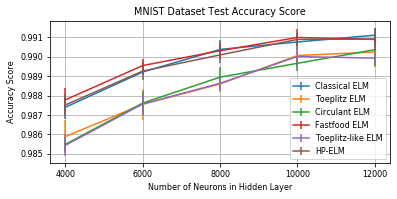

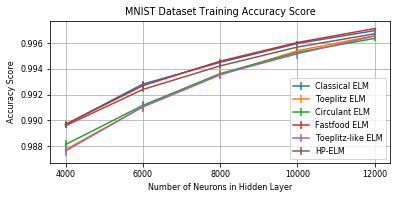

In [18]:
def getAllMeansAndStd(many_scores):
    means = []
    stds = []
    for scores in many_scores:
        (mean, std) = getMeansAndStd(scores)
        means.append(mean)
        stds.append(std)
    return (np.asarray(means), np.asarray(stds))

def getMeansAndStd(scores):
    scores = np.asarray(scores)
    mean = np.mean(scores, axis=-1)
    std = np.std(scores, axis=-1)
    return (mean, std)

start = 0
def plot_scores(scores, neurons, label, start=start, test=True):
    (mean, std) = getMeansAndStd(scores)
    plt.errorbar(neurons[start:], mean[start:, int(test)], std[start:, int(test)], label=label)

figure = plt.figure(figsize=(12/2.54, 5/2.54))

plt.rcParams.update({'font.size': 8})

plot_scores(classical_scores[:], neurons[:], "Classical ELM")

plot_scores(t_scores[:], neurons[:], "Toeplitz ELM")

plot_scores(c_scores[:], neurons[:], "Circulant ELM")

plot_scores(fastfood_scores[:], neurons[:], "Fastfood ELM")

plot_scores(low_rank[:], neurons[:], "Toeplitz-like ELM")

plot_scores(hpelm_scores[:], neurons[:], "HP-ELM")


plt.title("MNIST Dataset Test Accuracy Score")
plt.xlabel("Number of Neurons in Hidden Layer")
plt.ylabel("Accuracy Score")

plt.xticks(neurons[start:])
plt.legend()
plt.grid(True)

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

plt.savefig("mnist/mnist_score_test.eps", format='eps', bbox_inches = 'tight',
     pad_inches = 0)



figure = plt.figure(figsize=(12/2.54, 5/2.54))

plt.rcParams.update({'font.size': 8})

plot_scores(classical_scores[:], neurons[:], "Classical ELM", test=False)

plot_scores(t_scores[:], neurons[:], "Toeplitz ELM", test=False)

plot_scores(c_scores[:], neurons[:], "Circulant ELM", test=False)

plot_scores(fastfood_scores[:], neurons[:], "Fastfood ELM", test=False)

plot_scores(low_rank[:], neurons[:], "Toeplitz-like ELM", test=False)

plot_scores(hpelm_scores[:], neurons[:], "HP-ELM", test=False)

plt.title("MNIST Dataset Training Accuracy Score")
plt.xlabel("Number of Neurons in Hidden Layer")
plt.ylabel("Accuracy Score")

plt.xticks(neurons[start:])
plt.legend()
plt.grid(True)

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

plt.savefig("mnist/mnist_score_train.eps", format='eps', bbox_inches = 'tight',
    pad_inches = 0)

## Figure 4.6 (results with shuffled pixels) and results for Table 4.3

In [19]:
with open(f"mnist/results_permut.p", "rb") as file:
     [neurons, hpelm_scores, classical_scores, t_scores, c_scores, fastfood_scores, 
      low_rank] = pickle.load(file)     

In [20]:
with open(f"mnist/losers.p", "rb") as file:
     [vandermonde_4000, real_low_686_4000, 
                  real_low_392_4000, real_low_686_10000, real_low_392_10000] = pickle.load(file)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

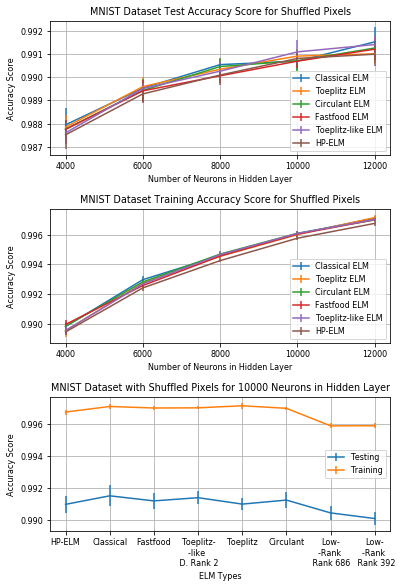

In [21]:
def getAllMeansAndStd(many_scores):
    means = []
    stds = []
    for scores in many_scores:
        (mean, std) = getMeansAndStd(scores)
        means.append(mean)
        stds.append(std)
    return (np.asarray(means), np.asarray(stds))

def getMeansAndStd(scores):
    scores = np.asarray(scores)
    mean = np.mean(scores, axis=-1)
    std = np.std(scores, axis=-1)
    return (mean, std)

start = 0
def plot_scores(scores, neurons, label, start=start, test=True):
    (mean, std) = getMeansAndStd(scores)
    plt.errorbar(neurons[start:], mean[start:, int(test)], std[start:, int(test)], label=label)

figure = plt.figure(figsize=(12/2.54, 18/2.54))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0.4, wspace = 0)

plt.subplot(3, 1, 1)
plt.rcParams.update({'font.size': 8})

plot_scores(classical_scores[:], neurons[:], "Classical ELM")

plot_scores(t_scores[:], neurons[:], "Toeplitz ELM")

plot_scores(c_scores[:], neurons[:], "Circulant ELM")

plot_scores(fastfood_scores[:], neurons[:], "Fastfood ELM")

plot_scores(low_rank[:], neurons[:], "Toeplitz-like ELM")

plot_scores(hpelm_scores[:], neurons[:], "HP-ELM")


plt.title("MNIST Dataset Test Accuracy Score for Shuffled Pixels")
plt.xlabel("Number of Neurons in Hidden Layer")
plt.ylabel("Accuracy Score")

plt.xticks(neurons[start:])
plt.legend()
plt.grid(True)


plt.subplot(3, 1, 2)
plt.rcParams.update({'font.size': 8})

plot_scores(classical_scores[:], neurons[:], "Classical ELM", test=False)

plot_scores(t_scores[:], neurons[:], "Toeplitz ELM", test=False)

plot_scores(c_scores[:], neurons[:], "Circulant ELM", test=False)

plot_scores(fastfood_scores[:], neurons[:], "Fastfood ELM", test=False)

plot_scores(low_rank[:], neurons[:], "Toeplitz-like ELM", test=False)

plot_scores(hpelm_scores[:], neurons[:], "HP-ELM", test=False)

plt.title("MNIST Dataset Training Accuracy Score for Shuffled Pixels")
plt.xlabel("Number of Neurons in Hidden Layer")
plt.ylabel("Accuracy Score")

plt.xticks(neurons[start:])
plt.legend()
plt.grid(True)

plt.savefig("mnist/mnist_perm_train.eps", format='eps', bbox_inches = 'tight',
    pad_inches = 0)

plt.subplot(3, 1, 3)
plt.rcParams.update({'font.size': 8})

table = []
number = -1

results = [hpelm_scores[number], classical_scores[number], fastfood_scores[number], low_rank[number], 
           t_scores[number], c_scores[number], real_low_686_10000, real_low_392_10000]
names = ["HP-ELM", "Classical", "Fastfood", "Toeplitz-\n-like \n D. Rank 2",
             "Toeplitz", "Circulant","Low-\n-Rank \n Rank 686", "Low-\n-Rank \n Rank 392"]

(means, stds) = getAllMeansAndStd(results)

plt.errorbar(names, means[:, 1], stds[:, 1], label="Testing")
plt.errorbar(names, means[:, 0], stds[:, 0], label="Training")

plt.title("MNIST Dataset with Shuffled Pixels for 10000 Neurons in Hidden Layer")
plt.ylabel("Accuracy Score")
plt.xlabel("ELM Types")
plt.grid(True)
plt.legend()  

plt.savefig("mnist/mnist_perm.eps", format='eps', bbox_inches = 'tight',
    pad_inches = 0)

results = [classical_scores[0], low_rank[0], vandermonde_4000, real_low_686_4000, real_low_392_4000]
names = ["Classical", "Toeplitz", "Vandermonde", "low-686", "low-392"]
(means, stds) = getAllMeansAndStd(results)

for i in range(len(names)):
    table.append([names[i], means[i], stds[i]])

## Table 4.3

In [22]:
table

[['Classical',
  array([0.98980556, 0.98795   ]),
  array([0.00028262, 0.00072284])],
 ['Toeplitz',
  array([0.98953611, 0.9876    ]),
  array([0.0002834 , 0.00048648])],
 ['Vandermonde',
  array([0.90066389, 0.89878333]),
  array([0.00021396, 0.00027938])],
 ['low-686', array([0.98964444, 0.98771667]), array([0.00018045, 0.00049131])],
 ['low-392', array([0.98933611, 0.9875    ]), array([0.0002873, 0.0002582])]]

# Train Toeplitz-like ELMs with different displacement ranks
## Execute with not shuffled pixels
### Execution will take much time!

In [23]:
def test_low_rank(rank, neurons_number=5000, trial_number=6, print_every=1,
               regression_tool="ridge_sklearn", alpha=1e-11, dev=6, **kwargs):
    
    training_score = []
    testing_score = []
    
    stddev = dev / ((28*28) ** 0.5)
    for i in range(trial_number):
        elm = ToeplitzLikeELM(hidden_neurons=[neurons_number], ranks=rank, is_classifier=True, activation="sigmoid", input_shape=x_train[0].shape, use_bias=True,
                     kernel_initializer=RandomNormal(0, stddev), bias_initializer=RandomNormal(0, 1), dev=stddev)
        elm.fit(x_train, y_train, regression_tool=regression_tool, alpha=alpha, **kwargs)
        training_score.append(elm.calculate_classification_accuracy(x_train, y_train))
        testing_score.append(elm.calculate_classification_accuracy(x_test, y_test))
        if (i + 1) % print_every == 0:
            print(f"{i + 1}/{trial_number} Training score: {training_score[i]:.{4}}. "
                  f"Testing score: {testing_score[i]:.{4}}")
        elm = None       
    return [training_score, testing_score]

In [24]:
neurons = []

rank_1 = []
rank_2 = []
rank_3 = []
rank_4 = []
rank_5 = []
rank_6 = []

In [26]:
for i in range(2, 6):
    n = i * 2000
    neurons.append(n)
    
    print(f"Neurons: {n}")
    
    print("Rank 1")
    rank_1.append(test_low_rank(rank=1, neurons_number=n))

    print("Rank 2")
    rank_2.append(test_low_rank(rank=2, neurons_number=n))
    
    print("Rank 3")
    rank_3.append(test_low_rank(rank=3, neurons_number=n))
    
    print("Rank 4")
    rank_4.append(test_low_rank(rank=4, neurons_number=n))

    print("Rank 5")
    rank_5.append(test_low_rank(rank=5, neurons_number=n))
    
    print("Rank 6")
    rank_6.append(test_low_rank(rank=6, neurons_number=n))

    result = [neurons, rank_1, rank_2, rank_3, rank_4, rank_5, rank_6]
    with open(f"mnist/low_rank_results{n}.p", "wb") as file:
        pickle.dump(result, file)

In [ ]:
results = [neurons, rank_1, rank_2, rank_3, rank_4, rank_5, rank_6]
with open(f"mnist/low_rank_results_temp.p", "wb") as file:
    pickle.dump(results, file)

# Results for Toeplitz-like ELMs (Figure 4.8)

In [27]:
with open(f"mnist/low_rank_results.p", "rb") as file:
    [neurons, rank_1, rank_2, rank_3, rank_4, rank_5, rank_6] = pickle.load(file)

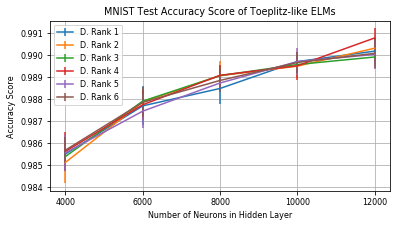

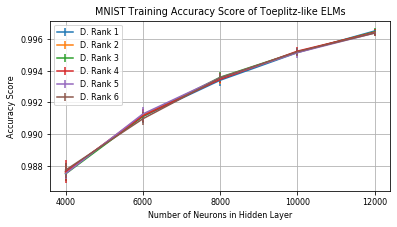

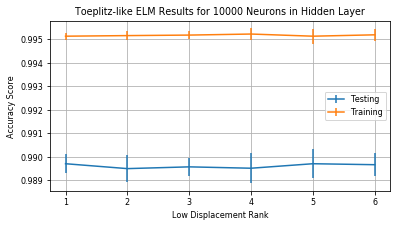

In [28]:
def getAllMeansAndStd(many_scores):
    means = []
    stds = []
    for scores in many_scores:
        (mean, std) = getMeansAndStd(scores)
        means.append(mean)
        stds.append(std)
    return (np.asarray(means), np.asarray(stds))

def getMeansAndStd(scores):
    scores = np.asarray(scores)
    mean = np.mean(scores, axis=-1)
    std = np.std(scores, axis=-1)
    return (mean, std)

start = 0
def plot_scores(scores, neurons, label, start=start, test=True):
    (mean, std) = getMeansAndStd(scores)
    plt.errorbar(neurons[start:], mean[start:, int(test)], std[start:, int(test)], label=label)

figure = plt.figure(figsize=(12/2.54, 6/2.54))
plt.rcParams.update({'font.size': 8})

plot_scores(rank_1, neurons, "D. Rank 1")

plot_scores(rank_2, neurons, "D. Rank 2")

plot_scores(rank_3, neurons, "D. Rank 3")

plot_scores(rank_4, neurons, "D. Rank 4")

plot_scores(rank_5, neurons, "D. Rank 5")

plot_scores(rank_6, neurons, "D. Rank 6")


plt.title("MNIST Test Accuracy Score of Toeplitz-like ELMs")
plt.xlabel("Number of Neurons in Hidden Layer")
plt.ylabel("Accuracy Score")

plt.xticks(neurons[start:])
plt.legend()
plt.grid(True)

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

plt.savefig("mnist/ranks_score_test.eps", format='eps', bbox_inches = 'tight',
    pad_inches = 0)

figure = plt.figure(figsize=(12/2.54, 6/2.54))
plt.rcParams.update({'font.size': 8})

plot_scores(rank_1, neurons, "D. Rank 1", test=False)

plot_scores(rank_2, neurons, "D. Rank 2", test=False)

plot_scores(rank_3, neurons, "D. Rank 3", test=False)

plot_scores(rank_4, neurons, "D. Rank 4", test=False)

plot_scores(rank_5, neurons, "D. Rank 5", test=False)

plot_scores(rank_6, neurons, "D. Rank 6", test=False)

plt.title("MNIST Training Accuracy Score of Toeplitz-like ELMs")
plt.xlabel("Number of Neurons in Hidden Layer")
plt.ylabel("Accuracy Score")

plt.xticks(neurons[start:])
plt.legend()
plt.grid(True)

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

plt.savefig("mnist/ranks_score_train.eps", format='eps', bbox_inches = 'tight',
    pad_inches = 0)

number = -2

results = [rank_1[number], rank_2[number], rank_3[number], rank_4[number], 
           rank_5[number], rank_6[number]]
names = [1, 2, 3, 4, 5, 6]
(means, stds) = getAllMeansAndStd(results)

figure = plt.figure(figsize=(12/2.54, 6/2.54))
plt.rcParams.update({'font.size': 8})

plt.errorbar(names, means[:, 1], stds[:, 1], label="Testing")
plt.errorbar(names, means[:, 0], stds[:, 0], label="Training")

plt.title("Toeplitz-like ELM Results for 10000 Neurons in Hidden Layer")
plt.ylabel("Accuracy Score")
plt.xlabel("Low Displacement Rank")
plt.grid(True)
plt.legend()  

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.savefig("mnist/mnist_score_10000.eps", format='eps', bbox_inches = 'tight',
    pad_inches = 0)